# Transferência de aprendizagem para classificação de imagens

![img](https://github.com/Jcnok/digitalinnovationone/blob/main/Unimed-BH%20-%20Ci%C3%AAncia%20de%20Dados/ML/rn.jpg?raw=true=50x50)

## Transferência de aprendizagem

* **O aprendizado de transferência consiste em pegar recursos aprendidos em um problema e aproveitá-los em um problema novo e semelhante.**
* **Neste exemplo irei aproveitar o modelo [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function).**
* **O método geralmente é feito para tarefas em que seu conjunto de dados tem poucos dados para treinar um modelo do zero.**
* **Foram testados outros modelos, que podem ser observados [aqui](https://keras.io/api/applications/).** 
* **Devido ao desempenho e limitação de hardware optei pelo modelo MobileNetV2, pois nas mil imagens testadas obtive uma acurácia acima de 95%.**

### Importação das bibliotecas

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
tf.__version__

'2.9.2'

### Carregamento das imagens

* **Para este estudo, serão utilizados 4mil imagens de forma aleatória e balanceada entre gatos e cães para o treinamento do modelo.**
* **Para o Teste(validação) foram separadas mil imagens dividas entre gatos e cães.**
* **O arquivo no formato zip está disponível para download [aqui](https://drive.google.com/file/d/10Zc6nKXZQDpWEj6zdyIW7ULCQ8ISd2B0/view).**
* **As imagens foram selecionadas à partir [Kaggle Cats and Dogs](https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765).** 

In [2]:
#Conectando ao google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Realizando a extração do arquivo zip.
path = '/content/drive/MyDrive/datasetpublico/cat_dog.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

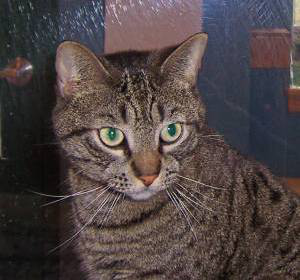

In [4]:
#Visualizando um imagem da pasta de treinamento cat.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.1.jpg')

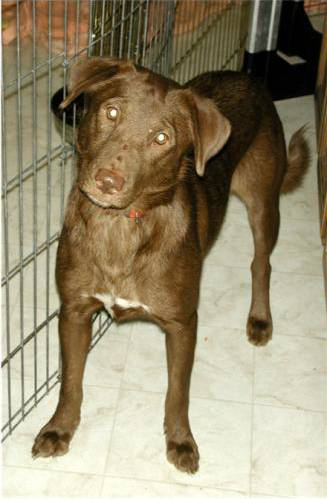

In [6]:
# visualizando uma imagem da pasta de treinamento dog.
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/dog/dog.1.jpg')

### Base de dados de treinamento e teste

#### Como usar o aumento de dados aleatórios
* **Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir diversidade de amostra artificialmente aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como inversão horizontal aleatória ou pequenas rotações aleatórias e zoom nas imagens. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento enquanto diminui o overfitting.**
* **Precisamos também normalizar e redimensionar todas as imagens para o mesmo padrão, para isso irei utilizar o método ImageDataGenerator conforme abaixo.**

In [7]:
# realizando o redimensionamento e a normalização no conjunto de treinamento.
gerador_treinamento = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
dataset_treinamento = gerador_treinamento.flow_from_directory('/content/cat_dog/training_set',
                                                        target_size = (128, 128),
                                                        batch_size = 128,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 4000 images belonging to 2 classes.


* **Foram encontradas 4000 imagens e 2 classes(cat e dog).**

* **Visualizando o comportamento das imagens apenas para uma melhor compreensão das alterações realizadas**.

Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


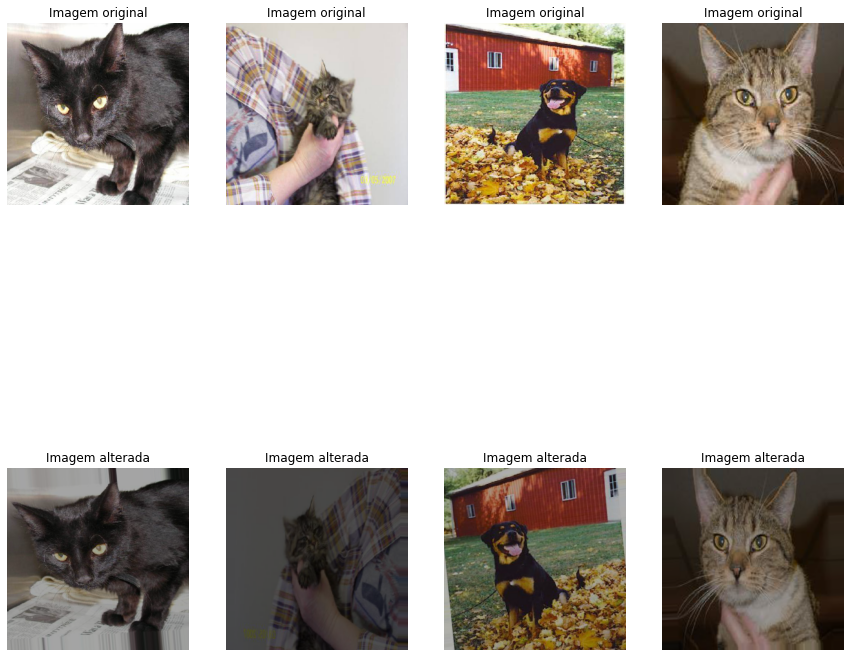

In [8]:
# Alterando as imagens.
datagen = ImageDataGenerator(
        rotation_range=7, # Rotação
        zoom_range=0.2, # aplicano 20% de zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brilho

# Imagem sem alteração.
datanorm = ImageDataGenerator()

# Conjunto com alterações
treino_alterado = datagen.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400), # padronizando todas as imagens
                  color_mode="rgb", # imagem colorida
                  batch_size=1, # numero de imagens extraída por batch
                  class_mode="binary", # classes
                  seed=2020 # para que os resultados sejam reproduzidos
                  )

# Conjunto sem sofrer alterações 
treino_normal = datanorm.flow_from_directory(
                  '/content/cat_dog/training_set',
                  target_size=(400, 400), 
                  color_mode="rgb", 
                  batch_size=1, 
                  class_mode="binary", 
                  seed=2020 
                  )

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

# Plotando 5 imagens
for i in range(4):

  # convertendo a imagem para inteiro
  image = next(treino_alterado)[0].astype('uint8')
  image2 = next(treino_normal)[0].astype('uint8')

  # alterando o formato (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = np.squeeze(image)
  image2 = np.squeeze(image2)


  # plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')

* **Podemos ver que além do redimensionamento de todas as imagens para 128 x 128, foram criadas novas imagens de forma invertida, com uma leve rotação, outras com 20% de zoom e com menos brilho etc...**

In [9]:
# realizando o redimensionamento e a normalização no conjunto de teste. 
gerador_teste = ImageDataGenerator(rescale=1./255)
dataset_teste = gerador_teste.flow_from_directory('/content/cat_dog/test_set',
                                                     target_size = (128, 128),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 1000 images belonging to 2 classes.


* **Foram localizadas 1000 imagens e 2 classes para o conjunto de teste.**

### Rede neural pré-treinada

* **Conforme mencionado, vamos utilizar o modelo 'MobileNetV2' que já foi treinado para outros fins, assim não precisamos implementar do zero, o que seria impraticável devido ao poder computacional da minha máquina e a quantidade de dados, certamente não obteria um resultado equivalente.**
* **A idéia é basicamente, utilizar todos os pesos das camadas do modelo que já foi treinado(know-how) e implementar apenas as camadas finais para o objetivo proposto, que nesse caso é saber identificar se o animal é uma gato ou cão.**  

In [10]:
# Carregando o modelo base MobileNetV2.
modelo_base = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False,
                                               input_shape = (128,128,3))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# informações das camadas do modelo base.
modelo_base.summary()

In [12]:
# visualizando a quantidade de camadas que o modelo  possui.
len(modelo_base.layers)

154

In [13]:
# Congelando os pesos das camadas para serem reaproveitadas.
for layer in modelo_base.layers:
  layer.trainable = False

* **O modelo possui 154 camadas que iremos reaproveitar, para isso foi utilizado o parametro False em layer.trainable para fixar os pesos das camadas.**

### Camada densa personalizada

In [14]:
# acessando a ultima camada do modelo base, pois após ela iremos adicionar a estrutura densa.
modelo_base.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

* **A última camada possui 1280 conexões para realizar a ligação com a nova camada irei utilizar a metade dessas conexões.**
* **Dropout irá descartar 20% das conexões para próxima camada, isso reduz o overfitting.**
* **Ao final criamos uma camada densa de 2 conexões para classificação (gato,cão).**

In [15]:
(1280 + 2) / 2

641.0

In [16]:
head_model = modelo_base.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

### Construção e treinamento da rede neural

In [17]:
# Agora literalmente realizando a ligação entre o modelo base e as camadas que foram implementadas.
network = Model(inputs = modelo_base.input, outputs = head_model)

In [ ]:
# visualizando as informações das camadas.
network.summary()

In [19]:
# Adicionamos as 6 camadas finais ao modelo.
len(network.layers)

160

In [40]:
# compilando o modelo.
network.compile(loss = 'categorical_crossentropy', optimizer='Adam', 
                metrics = ['accuracy'])

In [41]:
# Realizando o treimanto com 5 epocas.
historico = network.fit(dataset_treinamento, epochs=5)

Epoch 1/5
32/32 [==============================] - 25s 717ms/step - loss: 0.0815 - accuracy: 0.9693
Epoch 2/5
32/32 [==============================] - 23s 711ms/step - loss: 0.0679 - accuracy: 0.9750
Epoch 3/5
32/32 [==============================] - 23s 715ms/step - loss: 0.0594 - accuracy: 0.9768
Epoch 4/5
32/32 [==============================] - 26s 813ms/step - loss: 0.0489 - accuracy: 0.9810
Epoch 5/5
32/32 [==============================] - 23s 714ms/step - loss: 0.0462 - accuracy: 0.9812


### Avaliação da rede neural

In [42]:
# Avaliando a rede neural com o conjunto de teste.
network.evaluate(dataset_teste)

1000/1000 [==============================] - 11s 10ms/step - loss: 0.1227 - accuracy: 0.9680


[0.12272980809211731, 0.9679999947547913]

In [43]:
# Realizando as previsões no conjunto de teste.
previsoes = network.predict(dataset_teste)
previsoes

1000/1000 [==============================] - 9s 8ms/step


array([[5.0826448e-01, 4.9173552e-01],
       [9.9970347e-01, 2.9649935e-04],
       [1.0000000e+00, 5.4114020e-09],
       ...,
       [7.5198285e-02, 9.2480171e-01],
       [7.4719085e-04, 9.9925274e-01],
       [7.9893772e-09, 1.0000000e+00]], dtype=float32)

In [44]:
# previsões para o conjunto de teste.
previsoes = np.argmax(previsoes, axis = 1)
previsoes[:10] # 10 primeiros registros.

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [45]:
# classificação real do conjunto de teste.
dataset_teste.classes[:10] # 10 primeiros registros

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [46]:
# usando a função de acurária do sklearn apenas para comparar se os resultados estão corretos.
from sklearn.metrics import accuracy_score
accuracy_score(dataset_teste.classes, previsoes)

0.968

In [47]:
network.evaluate(dataset_teste)

1000/1000 [==============================] - 10s 10ms/step - loss: 0.1227 - accuracy: 0.9680


[0.12272980809211731, 0.9679999947547913]

* **Conforme o resultado, tivemos 96.7% de acurácia no conjunto de teste.**
* **Vamos plotar o gráfico da matriz de conjusão.**

In [48]:
dataset_treinamento.class_indices

{'cat': 0, 'dog': 1}

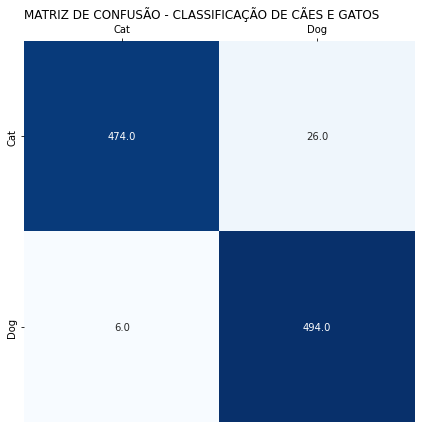

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(dataset_teste.classes, previsoes)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Matriz de confusão - Classificação de Cães e Gatos'.upper()
plt.title(title, loc='left')
plt.show()

* **Pela matriz podemos ver que o modelo acertou 484 gatos dos 500 e errou 16.**
* **O modelo acertou 483 Cães e classificou 17 de forme equivocada.**


In [50]:
from sklearn.metrics import classification_report
print(classification_report(dataset_teste.classes, previsoes))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       500
           1       0.95      0.99      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



* **O modelo teve um resultado bem satisfatório para detectar ambas imagens.**


# Salvar e carregar a rede neural

In [51]:
# Salvando os parametros do modelo.
model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [52]:
# Salvando os pesos das camadas.
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [ ]:
# visualizando o arquivo.json
with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

In [54]:
#Carregando o modelo salvo.
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
# conferindo as informações das camadas.
network_loaded.summary()

* **Com o modelo salvo podemos criar uma aplicação para consumir o modelo e classificar imagens de cães e gatos.**

# Classificação de uma única imagem

* **Vamos testar em uma única imagem para simular uma aplicação.**

In [56]:
# carregando uma imagem
imagem = cv2.imread('/content/cat_dog/test_set/dog/dog.3506.jpg')

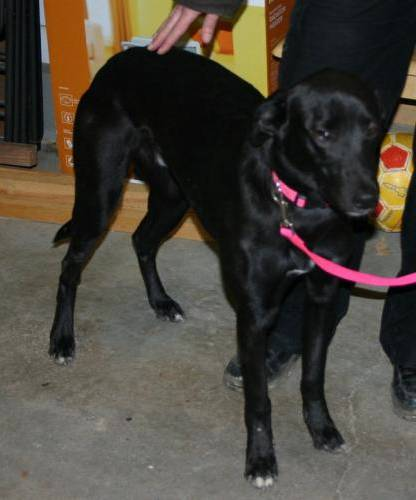

In [57]:
cv2_imshow(imagem)

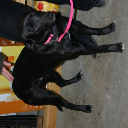

In [58]:
# Alterando para o tamanho padrão e rotacioando a imagem para dificultar a classificação.
imagem = cv2.resize(imagem, (128, 128))
imagem = cv2.rotate(imagem, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(imagem)

In [59]:
# Normalizando a imagem.
imagem = imagem / 255
imagem

array([[[0.07843137, 0.05882353, 0.04705882],
        [0.08235294, 0.0627451 , 0.05098039],
        [0.09803922, 0.07843137, 0.06666667],
        ...,
        [0.43529412, 0.44313725, 0.44705882],
        [0.41568627, 0.42352941, 0.42745098],
        [0.41176471, 0.41960784, 0.41960784]],

       [[0.09019608, 0.07058824, 0.05882353],
        [0.07058824, 0.05098039, 0.03921569],
        [0.07843137, 0.05882353, 0.05098039],
        ...,
        [0.44313725, 0.45490196, 0.45882353],
        [0.41176471, 0.41960784, 0.42352941],
        [0.4       , 0.40784314, 0.40784314]],

       [[0.07843137, 0.05882353, 0.04705882],
        [0.0745098 , 0.05490196, 0.04313725],
        [0.07058824, 0.05098039, 0.03921569],
        ...,
        [0.40784314, 0.41568627, 0.41960784],
        [0.4       , 0.40784314, 0.41568627],
        [0.41960784, 0.42745098, 0.42745098]],

       ...,

       [[0.09411765, 0.09019608, 0.08627451],
        [0.09411765, 0.08627451, 0.08235294],
        [0.09019608, 0

In [60]:
# Conferindo o formato
imagem.shape

(128, 128, 3)

In [61]:
# necessário realizar o reshape para que o modelo entenda o formato.
imagem = imagem.reshape(1,128,128,3)

In [62]:
# Realizando a previsão.
previsao = network_loaded(imagem)
previsao

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[8.062901e-05, 9.999194e-01]], dtype=float32)>

In [63]:
previsao = np.argmax(previsao)
previsao

1

In [64]:
dataset_teste.class_indices

{'cat': 0, 'dog': 1}

In [66]:
if previsao == 0:
  print('O modelo identificou que o animal é um: Gato')
else:
  print('O modelo identificou que o animal é um: Cão')

O modelo identificou que o animal é um: Cão


* **Veja que mesmo rotacionando a imagem o modelo conseguiu prever corretamente a imagem com uma precisão de 99%.**
* **Podemos tentar melhorar a precisão acrescentando uma técnica de ajuste fino, porém ficará para um outro estudo.**
* **Nesse momento o objetivo será implementar o modelo em uma aplicação web com o streamlit e desponibilizá-lo para que qualquer pessoa possa testar o resultado com suas próprias imagens.**
* *Mãos a obra....*